In [3]:
from flexddm.models.nsbi_models import nDDMfz, nDMCfz, nSSPfz, nDSTPfz 
from flexddm.main import fit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.api as sm
import pickle as pkl

def preprocessing(df): 

    tmp_df = df.copy()

    return (
        tmp_df
        .rename(columns={
            'subj_idx':'id', 
            'response':'accuracy', 
            # 'rt':'RT', 
            # 'congruency':'Condition'
        })
        .assign(
            congruency=lambda x: x['congruency'].map({1:'congruent', 0:'incongruent'}),
            accuracy=lambda x: np.where(x['accuracy'] == 1,1,0),
        )
    )

def regplot_with_corr(
    data=None,
    x="x",
    y="y",
    cor_anonot=True,
    reg_anonot=False,
    annot_kws={
        "fontsize": 8,
        "xy": (0.95, 0.05),
        "ha": 'right',
        "va": 'bottom'
    },
    scatter_kws={
        's': 40,
        "alpha": 0.4
    },
    ax=None,
    **kwargs
):
    """

    Example:
    --------
    >>> Example usage
    >>> import pandas as pd
    >>> data = pd.DataFrame({'x': [1, 2, 3, 4, 5], 'y': [2, 3, 5, 7, 11]})
    >>> regplot_with_corr(data)
    >>> plt.show()
    """
    if ax is None:
        ax = plt.gca()
    if data is not None:
        data_x = data[x]
        data_y = data[y]
    else: 
        data_x = x
        data_y = y

    # Plot regression line and scatter plot
    sns.regplot(
        x=data_x,
        y=data_y,
        ci=None if len(np.unique(data_y)) == 1 else 95,
        scatter_kws=scatter_kws,
        ax=ax
    )

    annot_text = ""
    if cor_anonot:
        # Calculate Pearson correlation
        correlation, p_value = pearsonr(data_x, data_y)
        # if np.isnan(correlation):
        #     correlation = 0
        # if np.isnan(p_value):
        #     p_value = 1
        p_str = "p < 0.001" if p_value < 0.001 else f"p = {p_value:.3f}"
        annot_text += f"$r={correlation:.2f}$\n${p_str}$"

    if reg_anonot:
        # Calculate regression coefficients
        X = sm.add_constant(data_x)  # Adds a constant term to the predictor
        model = sm.OLS(data_y, X).fit()
        intercept, slope = model.params
        annot_text += f"\n$\\beta_0={intercept:.2f}$\n$\\beta_1={slope:.2f}$"

    # Annotate the plot with correlation, p-value, intercept, and slope
    if annot_text != "":
        ax.annotate(
            annot_text,
            **annot_kws,
            xycoords='axes fraction',
            bbox=dict(
                boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'
            )
        )
    
    return ax

def plots(df_nsbi, df_flexddm, model_name ="DDM"):
    """
    绘制多个变量的回归图，并标注相关性和 p 值。
    
    参数:
        df_nsbi: 包含自变量的 DataFrame
        df_flexddm: 包含因变量的 DataFrame
    """
    var_cols = df_nsbi.columns[1:]
    
    fig, axes = plt.subplots(1, len(var_cols), sharex=False, sharey=False, figsize=(4 * len(var_cols), 3))
    
    for i, col in enumerate(var_cols):
        regplot_with_corr(
            x=df_nsbi[col],
            y=df_flexddm[col],
            ax=axes[i]
        )
        axes[i].set_title(col)
        axes[i].set_xlabel("NSBI")
        if i == 0:
            axes[i].set_ylabel("FlexDDM")
        else: 
            axes[i].set_ylabel("")
    plt.tight_layout()
    plt.savefig(f"./validation/{model_name}_comp_flex_nsbi.pdf", dpi=300, bbox_inches="tight")
    plt.show()

ALL results are storied in the folder [validation](./validation/model_validation.png). 

Note, each model fitting procedure cost 1 to 2 hour. 

## Load data

In [4]:
with open('output.pkl', 'rb') as file:
    df_dict = pkl.load(file)

In [5]:
for model in df_dict.keys():
    if "sim_data" in df_dict[model]:
        # 对 sim_data 进行预处理
        df_dict[model]["sim_data"] = preprocessing(df_dict[model]["sim_data"])

In [4]:
df_dict["DDM"]["sim_data"]

,rt,accuracy,congruency,id
0,0.135431,1,incongruent,0
1,0.168431,1,congruent,0
2,0.172431,0,incongruent,0
3,0.164431,1,congruent,0
4,0.187431,0,incongruent,0
...,...,...,...,...
99995,0.783407,1,congruent,99
99996,0.755407,1,incongruent,99
99997,0.775407,0,congruent,99
99998,0.878407,1,incongruent,99


## Fitting

In [5]:
DDM = nDDMfz() 
SSP = nSSPfz()
DMC = nDMCfz()
DSTP = nDSTPfz() 

In [ ]:
fit(
    [DDM], 
    input_data=df_dict["DDM"]["sim_data"], 
    input_data_id="id", 
    input_data_congruency="congruency", 
    input_data_rt="rt", 
    input_data_accuracy="accuracy",
    startingParticipants=0, endingParticipants=99, 
    posterior_predictive_check=False, 
    output_fileName='recovery.csv'
)

In [ ]:
fit(
    [SSP],
    input_data=df_dict["SSP"]["sim_data"],
    input_data_id="id", 
    input_data_congruency="congruency", 
    input_data_rt="rt", 
    input_data_accuracy="accuracy",
    startingParticipants=25, endingParticipants=25, 
    posterior_predictive_check=False, 
    output_fileName='recovery.csv'
)

In [ ]:
fit(
    [DMC],
    input_data=df_dict["DMC"]["sim_data"],
    input_data_id="id", 
    input_data_congruency="congruency", 
    input_data_rt="rt", 
    input_data_accuracy="accuracy",
    startingParticipants=0, endingParticipants=99, 
    posterior_predictive_check=False, 
    output_fileName='recovery.csv'
)

In [ ]:
fit(
    [DSTP],
    input_data=df_dict["DSTP"]["sim_data"],
    input_data_id="id", 
    input_data_congruency="congruency", 
    input_data_rt="rt", 
    input_data_accuracy="accuracy",
    startingParticipants=0, endingParticipants=99, 
    posterior_predictive_check=False, 
    output_fileName='recovery.csv'
)

## Plot

In [86]:
DDM_nsbi =  df_dict["DDM"]["fitted_param"]
DDM_flex = pd.read_csv("fit/fitted_parameters/nDDMfz_recovery.csv")
DMC_nsbi =  df_dict["DMC"]["fitted_param"]
DMC_flex = pd.read_csv("fit/fitted_parameters/nDMCfz_recovery.csv")
SSP_nsbi =  df_dict["SSP"]["fitted_param"]
SSP_flex = pd.read_csv("fit/fitted_parameters/nSSPfz_recovery.csv")
DSTP_nsbi =  df_dict["DSTP"]["fitted_param"]
DSTP_flex = pd.read_csv("fit/fitted_parameters/nDSTPfz_recovery.csv")

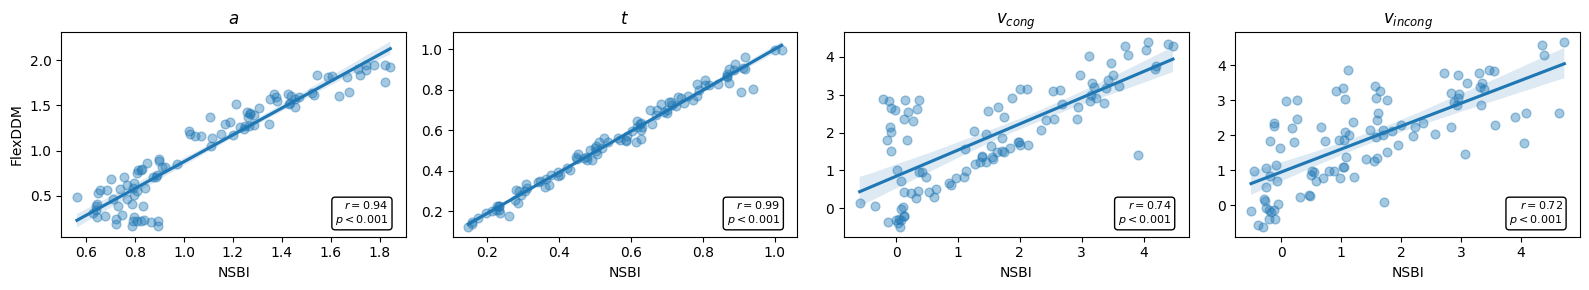

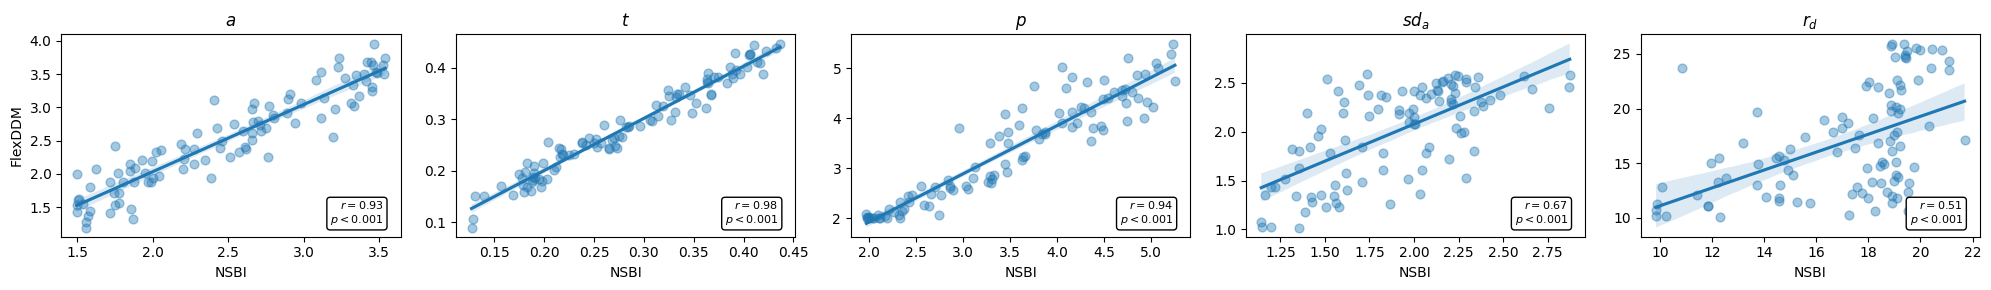

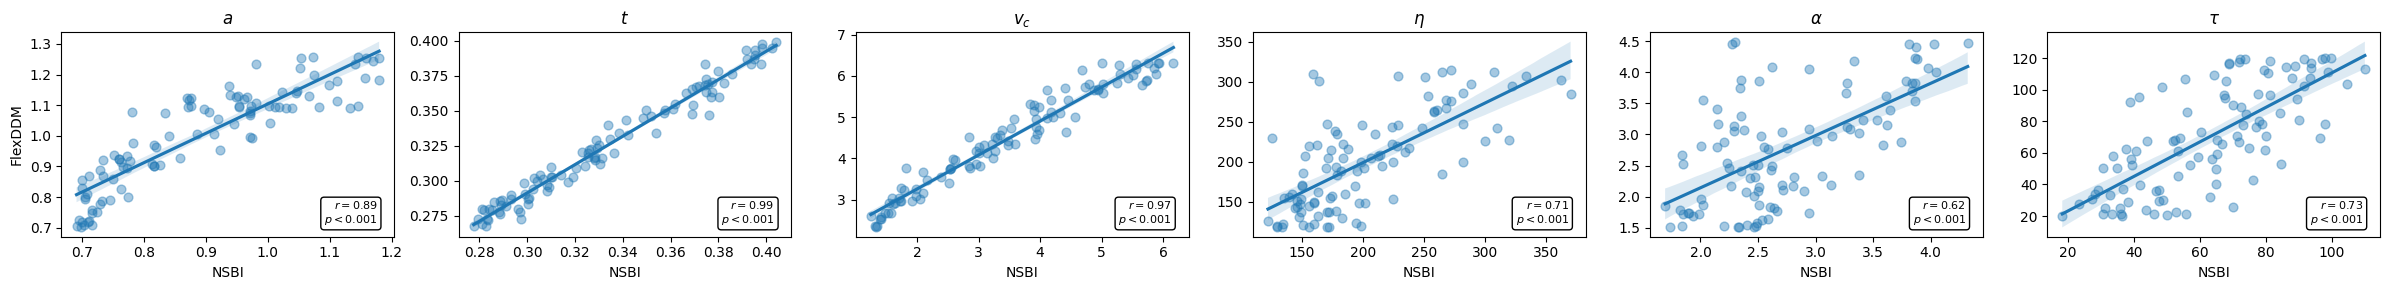

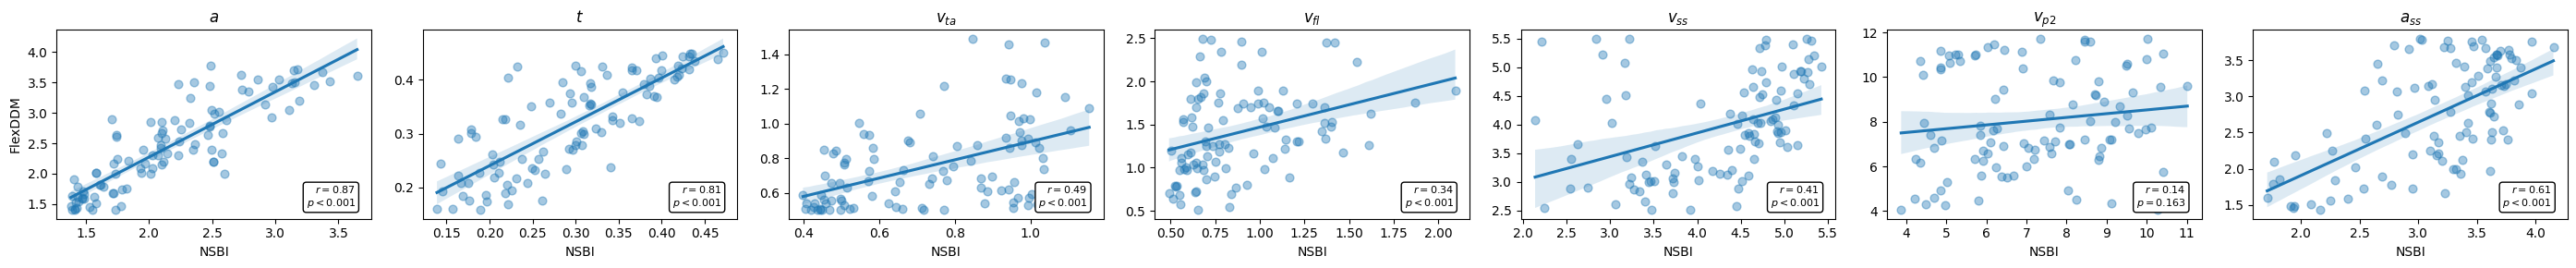

In [88]:
plots(DDM_nsbi, DDM_flex, "DDM")
plots(SSP_nsbi, SSP_flex, "SSP")
plots(DMC_nsbi, DMC_flex, "DMC")
plots(DSTP_nsbi, DSTP_flex, "DSTP")